In [34]:
import numpy as np
import utils

In [36]:
# https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
# https://github.com/macbuse/macbuse.github.io/blob/master/PROG/convolve.py
def convolve2D(image: np.ndarray, kernel: np.ndarray, mode = "valid", correlation = False):
    # Cross correlation or Convolution depends on the orientation of the kernel
    kernel = kernel if correlation else np.flipud(np.fliplr(kernel))

    # Gather shapes of kernel + image + padding
    x_kernel_size, y_kernel_size = kernel.shape
    x_image_size, y_image_size = image.shape[0:2]

    if mode == "valid":
        # Ouput matrix size of a full convolution
        x_output = int(x_image_size - x_kernel_size + 1)
        y_output = int(y_image_size - y_kernel_size + 1)
        output = np.zeros((x_output, y_output))

        for y in range(0, y_image_size - y_kernel_size + 1):
            for x in range(0, x_image_size - x_kernel_size + 1):
                output[x, y] = (kernel * image[x: x + x_kernel_size, y: y + y_kernel_size]).sum()
    
    elif mode == "full":
        # Output matrix size of a valid convolution
        x_output = int((x_image_size + x_kernel_size - 1))
        y_output = int((y_image_size + y_kernel_size - 1))
        image_padded = np.pad(image, x_kernel_size - 1, mode='constant', constant_values=(0))
        output = np.zeros((x_output, y_output))

        for x in range(0, output.shape[0]):
            for y in range(0, output.shape[1]):
                output[x, y] = (kernel * image_padded[x: x + x_kernel_size, y: y + y_kernel_size]).sum()
        
    return output

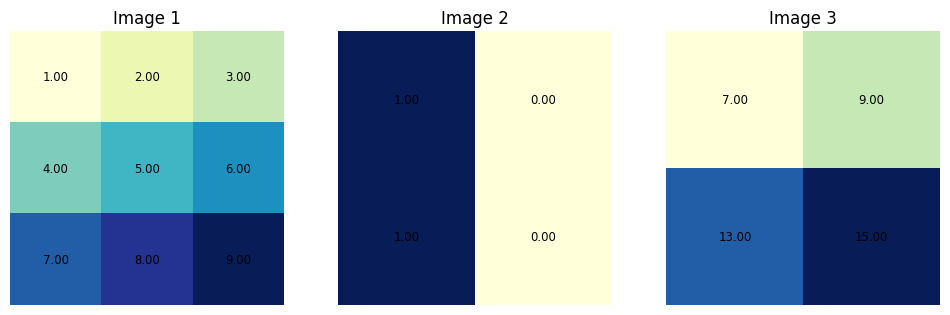

In [37]:
# 1x1 filter

kernel = np.array([[1]])

# 2x2 filter
kernel = np.array([[1, 0], [1, 0]])

# 3x3 filter
# kernel = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])

# 4x4 filter
# kernel = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1]])

# Ascending 3x3 matrix
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Ascending 5x5 matrix
# a = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [21, 22, 23, 24, 25]])

b = convolve2D(a, kernel, mode = 'valid', correlation = True)
utils.display_images([a, kernel, b])

In [4]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update params and return input gradient
        pass

In [5]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
    
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    
    def backward(self, output_gradient, learning_rate):
        # Update params and return input gradient
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return np.dot(self.weights.T, output_gradient)

In [6]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [7]:
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x: 1 - np.tanh(x)**2
        super().__init__(tanh, tanh_prime)

In [8]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        tmp = np.tile(self.output, n)
        return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [33]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth # number of kernels
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size) # multiple 3D kernels
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)
    
    
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                # self.output[i] += signal.correlate2d(self.input[j], self.kernels[i][j], "valid")
                self.output[i] += convolve2D(self.input[j], self.kernels[i, j])
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = convolve2D(self.input[j], output_gradient[i], "valid", correlation = True)
                input_gradient[j] += convolve2D(output_gradient[i], self.kernels[i, j], "full")
        
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient



In [22]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    
    def forward(self, input):
        return np.reshape(input, self.output_shape)
    
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [23]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)
            
        super().__init__(sigmoid, sigmoid_prime)

In [24]:
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

### XOR-problem

In [25]:
X = np.reshape([[0,0], [0,1], [1,0], [1,1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

In [26]:
network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

In [27]:
epochs = 100
learning_rate = 0.1

In [28]:
for epoch in range(epochs):
    error = 0
    for x, y in zip(X, Y):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate error
        error += mse(y, output)

        # Backward pass
        grad = mse_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
        
    error /= len(X)
    print(f"Epoch {epoch}, error: {error}")

Epoch 0, error: 0.4734077373432598
Epoch 1, error: 0.4197199483866649
Epoch 2, error: 0.4061687561408821
Epoch 3, error: 0.39241196714882665
Epoch 4, error: 0.37900146914534266
Epoch 5, error: 0.3672012639320885
Epoch 6, error: 0.3574406795135354
Epoch 7, error: 0.34915887559166225
Epoch 8, error: 0.3416796328513097
Epoch 9, error: 0.3345790742515749
Epoch 10, error: 0.3276451428067785
Epoch 11, error: 0.3207995149176902
Epoch 12, error: 0.31404829194250616
Epoch 13, error: 0.3074500342369214
Epoch 14, error: 0.3010913008261342
Epoch 15, error: 0.29506584926904456
Epoch 16, error: 0.28945734930302114
Epoch 17, error: 0.28432707683768754
Epoch 18, error: 0.27970784227488804
Epoch 19, error: 0.2756040584808127
Epoch 20, error: 0.2719964016613555
Epoch 21, error: 0.2688487828293907
Epoch 22, error: 0.2661155228118095
Epoch 23, error: 0.2637473650857362
Epoch 24, error: 0.26169578268802335
Epoch 25, error: 0.25991562791224865
Epoch 26, error: 0.25836646611035907
Epoch 27, error: 0.25701300

# MNIST Problem

In [29]:
from keras.datasets import mnist
from keras.utils import np_utils

In [30]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype('float32') / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

In [31]:
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

epochs = 10
learning_rate = 0.1

for epoch in range(epochs):
    error = 0
    for x, y in zip(x_train, y_train):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate error
        error += binary_cross_entropy(y, output)

        # Backward pass
        grad = binary_cross_entropy_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    
    error /= len(x_train)
    print(f"Epoch {epoch}, error: {error}")

for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"Predicted: {np.argmax(output)}, actual: {np.argmax(y)}")

Epoch 0, error: 0.3842429981766866
Epoch 1, error: 0.0904590681185435
Epoch 2, error: 0.08087092308807678
Epoch 3, error: 0.04212235551378086
Epoch 4, error: 0.03797345861954363
Epoch 5, error: 0.012140596749584322
Epoch 6, error: 0.01009384670026201
Epoch 7, error: 0.010154601586890872
Epoch 8, error: 0.007422624155806277
Epoch 9, error: 0.0064671668470632215
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0,